#### Author
Victor Aleksandrin

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=fb9f43de74cb4dc6afe4e8f54a71e85b)

#### Idea
Finetune tf-idf + logreg parameters with optuna. 

#### Data
4500 cryptonews titles labeled as positive, neutral or negative – [CSV](https://drive.google.com/file/d/1YqvAtWAQNeXvw-71TWtNmisAa9SN8gmj/view) (not to be shared outside of the project!)

#### Result
Finetuned model obtains about 72 accuracy score.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

from typing import Dict, Any
from copy import deepcopy

import optuna

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina' # sharper plots

### Read data

In [2]:
DATA_PATH = '../data/20190110_train_4500.csv'

In [3]:
dataset = pd.read_csv(DATA_PATH)

In [4]:
dataset.head()

,title,sentiment
0,Bitcoin Market Has Run Out of Juice: Cryptocur...,Negative
1,Bitcoin Core 0.14.0 Speeds Up Blockchain Synci...,Positive
2,Thinking of Travelling With Bitcoin? With Thes...,Positive
3,Investors Carried Out Mental Gymnastics to Jus...,Negative
4,"Bitcoin Price Holds Above $8,500 as Market Fig...",Positive


### Params tuning

In [5]:
temp_cfg = {
    "tfidf": {
        "ngram_range": (1, 5), 
        "min_df": 0.0, 
        "analyzer": "char", 
        "max_features": 20000,
        "stop_words": "english",
        "norm": "l2",
        "use_idf": True,
        "binary": False,
        "sublinear_tf": False,
        "max_df": 0.75
    },
    "logit": {
        "C": 1.5, 
        "random_state": 17, 
        "multi_class": "multinomial", 
        "solver": "lbfgs", 
        "n_jobs": 4, 
        "max_iter": 500,
        "penalty": "l2"
    }
}

In [6]:
def train_model(cfg: Dict[str, Any], dataset: pd.DataFrame) -> float:
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
    
    title_transformer = TfidfVectorizer(**cfg["tfidf"])
    logit = LogisticRegression(**cfg["logit"])

    model = Pipeline([('tfidf', title_transformer), ('logit', logit)])
    
    return cross_val_score(
        estimator=model, 
        X=dataset['title'], 
        y=dataset['sentiment'], 
        cv=skf,
        n_jobs=5
    ).mean()

In [7]:
def objective(trial: optuna.trial.Trial, cfg: Dict[str, Any], dataset:pd.DataFrame) -> float:
    
    trial_cfg = deepcopy(cfg)
    
    # tf-idf params
    ngram_range_max = trial.suggest_int("ngram_range_max", 1, 7, step=1)
    trial_cfg["tfidf"]["ngram_range"] = (1, ngram_range_max)
    
    trial_cfg["tfidf"]["min_df"] = trial.suggest_float("min_df", 0, 0.3, step=0.001)
    trial_cfg["tfidf"]["max_df"] = trial.suggest_float("max_df", 0.7, 1.0, step=0.001)
    trial_cfg["tfidf"]["analyzer"] = trial.suggest_categorical("analyzer", ["word", "char"])

    
    # logreg
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    trial_cfg["logit"]["solver"] = solver
    
    trial_cfg["logit"]["C"] = trial.suggest_float("C", 1, 3, step=0.001)
    
    if solver == "liblinear":
        trial_cfg["logit"]["multi_class"] = "ovr"
        trial_cfg["logit"]["n_jobs"] = 1
    else:
        trial_cfg["logit"]["multi_class"] = trial.suggest_categorical("multi_class", ["ovr", "multinomial"])
    
    if solver == "lbfgs":
        trial_cfg["logit"]["penalty"] = "l2"
    else:
        trial_cfg["logit"]["penalty"] = trial.suggest_categorical("penalty", ["l1", "l2"])
    
    trial.set_user_attr("cfg", trial_cfg)
    
    accuracy = train_model(trial_cfg, dataset)
    
    return accuracy

In [8]:
def tune_logreg(
    cfg: Dict[str, Any], 
    dataset: pd.DataFrame, 
    n_trials: int = 100
) -> optuna.trial._frozen.FrozenTrial:
    
    pruner: optuna.pruners.BasePruner = optuna.pruners.MedianPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(lambda x: objective(x, cfg, dataset), n_trials=n_trials)
    
    return study.best_trial

In [9]:
best_trial = tune_logreg(temp_cfg, dataset, 100)

[I 2022-04-11 17:39:30,587] A new study created in memory with name: no-name-da9a6151-9e63-48d9-b25d-255f868875e6
[I 2022-04-11 17:39:31,324] Trial 0 finished with value: 0.5010989010989011 and parameters: {'ngram_range_max': 2, 'min_df': 0.036000000000000004, 'max_df': 0.728, 'analyzer': 'word', 'solver': 'lbfgs', 'C': 1.708, 'multi_class': 'multinomial'}. Best is trial 0 with value: 0.5010989010989011.
[I 2022-04-11 17:39:31,805] Trial 1 finished with value: 0.5362338210636783 and parameters: {'ngram_range_max': 3, 'min_df': 0.223, 'max_df': 0.741, 'analyzer': 'char', 'solver': 'liblinear', 'C': 1.883, 'penalty': 'l2'}. Best is trial 1 with value: 0.5362338210636783.
[I 2022-04-11 17:39:32,008] Trial 2 finished with value: 0.5177821739182881 and parameters: {'ngram_range_max': 1, 'min_df': 0.042, 'max_df': 0.87, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 1.845, 'multi_class': 'multinomial'}. Best is trial 1 with value: 0.5362338210636783.
[I 2022-04-11 17:39:32,646] Trial 3 finished

[I 2022-04-11 17:40:10,408] Trial 28 finished with value: 0.5992545325146862 and parameters: {'ngram_range_max': 5, 'min_df': 0.117, 'max_df': 0.86, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 1.339, 'multi_class': 'multinomial'}. Best is trial 16 with value: 0.7217881569582997.
[I 2022-04-11 17:40:10,725] Trial 29 finished with value: 0.49956043956043955 and parameters: {'ngram_range_max': 3, 'min_df': 0.038, 'max_df': 0.7809999999999999, 'analyzer': 'word', 'solver': 'lbfgs', 'C': 1.639, 'multi_class': 'multinomial'}. Best is trial 16 with value: 0.7217881569582997.
[I 2022-04-11 17:40:12,807] Trial 30 finished with value: 0.6480037635251685 and parameters: {'ngram_range_max': 7, 'min_df': 0.05, 'max_df': 0.833, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 2.9939999999999998, 'multi_class': 'multinomial'}. Best is trial 16 with value: 0.7217881569582997.
[I 2022-04-11 17:40:15,587] Trial 31 finished with value: 0.7209090360791788 and parameters: {'ngram_range_max': 6, 'min_df': 0.002,

[I 2022-04-11 17:41:00,113] Trial 56 finished with value: 0.6394427087731149 and parameters: {'ngram_range_max': 5, 'min_df': 0.059000000000000004, 'max_df': 1.0, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 2.0090000000000003, 'multi_class': 'multinomial'}. Best is trial 16 with value: 0.7217881569582997.
[I 2022-04-11 17:41:01,823] Trial 57 finished with value: 0.562142314326727 and parameters: {'ngram_range_max': 7, 'min_df': 0.222, 'max_df': 0.974, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 2.182, 'multi_class': 'ovr'}. Best is trial 16 with value: 0.7217881569582997.
[I 2022-04-11 17:41:02,267] Trial 58 finished with value: 0.5303014438909059 and parameters: {'ngram_range_max': 6, 'min_df': 0.013000000000000001, 'max_df': 0.957, 'analyzer': 'word', 'solver': 'lbfgs', 'C': 2.403, 'multi_class': 'multinomial'}. Best is trial 16 with value: 0.7217881569582997.
[I 2022-04-11 17:41:04,268] Trial 59 finished with value: 0.6471256076525012 and parameters: {'ngram_range_max': 7, 'min_df':

[I 2022-04-11 17:41:53,750] Trial 84 finished with value: 0.6930186608122941 and parameters: {'ngram_range_max': 6, 'min_df': 0.014, 'max_df': 0.9369999999999999, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 2.041, 'multi_class': 'multinomial'}. Best is trial 74 with value: 0.723327100999988.
[I 2022-04-11 17:41:55,646] Trial 85 finished with value: 0.6785269176487618 and parameters: {'ngram_range_max': 6, 'min_df': 0.024, 'max_df': 0.954, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 1.8290000000000002, 'multi_class': 'multinomial'}. Best is trial 74 with value: 0.723327100999988.
[I 2022-04-11 17:41:57,447] Trial 86 finished with value: 0.7015835755901618 and parameters: {'ngram_range_max': 5, 'min_df': 0.007, 'max_df': 0.8799999999999999, 'analyzer': 'char', 'solver': 'lbfgs', 'C': 1.7930000000000001, 'multi_class': 'multinomial'}. Best is trial 74 with value: 0.723327100999988.
[I 2022-04-11 17:41:58,804] Trial 87 finished with value: 0.6903829869362251 and parameters: {'ngram_range_m

In [10]:
best_trial.user_attrs["cfg"]

{'tfidf': {'ngram_range': (1, 6),
  'min_df': 0.0,
  'analyzer': 'char',
  'max_features': 20000,
  'stop_words': 'english',
  'norm': 'l2',
  'use_idf': True,
  'binary': False,
  'sublinear_tf': False,
  'max_df': 0.9109999999999999},
 'logit': {'C': 1.7770000000000001,
  'random_state': 17,
  'multi_class': 'multinomial',
  'solver': 'lbfgs',
  'n_jobs': 4,
  'max_iter': 500,
  'penalty': 'l2'}}

### Learning Curves

In [11]:
best_cfg = best_trial.user_attrs["cfg"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

title_transformer = TfidfVectorizer(**best_cfg["tfidf"])
logit = LogisticRegression(**best_cfg["logit"])

model = Pipeline([('tfidf', title_transformer), ('logit', logit)])

In [12]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model, 
    X=dataset['title'], 
    y=dataset['sentiment'], 
    train_sizes=np.linspace(.1, 1, 10),
    cv=skf, 
    n_jobs=5, 
    verbose=1
)

[learning_curve] Training set sizes: [ 364  728 1092 1457 1821 2185 2550 2914 3278 3643]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   21.0s finished


In [13]:
# helper function

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

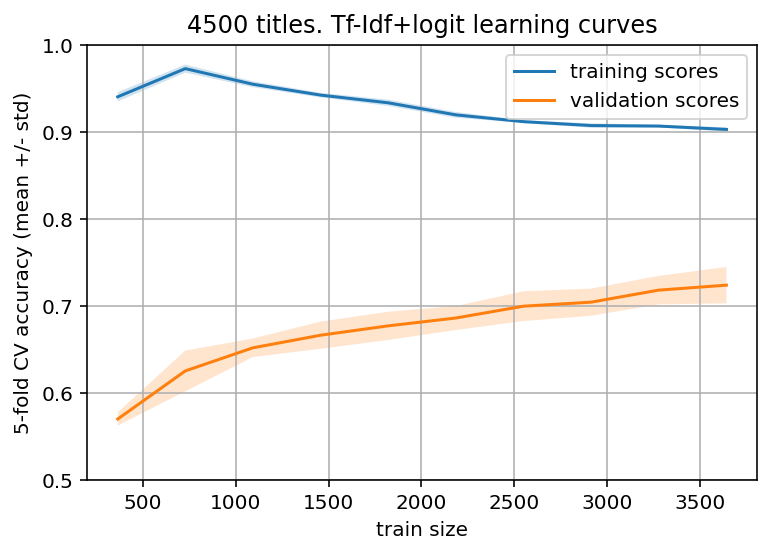

In [14]:
plot_with_err(train_sizes, train_scores, label='training scores')
plot_with_err(train_sizes, val_scores, label='validation scores')
plt.xlabel('train size')
plt.ylabel('5-fold CV accuracy (mean +/- std)')
plt.legend()
plt.grid(True);
plt.ylim(.5, 1)
plt.title('4500 titles. Tf-Idf+logit learning curves')
plt.savefig('../figures/20220408_learning_curves_baseline_model_4500_titles.png',
           dpi=300)